In [22]:
import os
import numpy as np
import random

In [23]:
def load_data(dataset="datasets",
              transformation=None,
              n_train=None,
              n_test=None,
              batch_size=128,
              data_root="/home/pml02"):
    """
    Lazy-loading dataset iterator for large Imagenet-like datasets split into .npz batch files.
    Returns two generators: train_gen and test_gen.
    """

    dataset_path = os.path.join(data_root, dataset)

    # --- Find all .npz files --------------------------------------------------
    files = sorted([
        os.path.join(dataset_path, f)
        for f in os.listdir(dataset_path)
        if f.endswith(".npz")
    ])

    if len(files) == 0:
        raise ValueError(f"No .npz files found in {dataset_path}")

    # --- First pass: read file sizes without loading data ----------------------
    file_sizes = []
    for f in files:
        with np.load(f) as npz:
            file_sizes.append(len(npz["labels"]))  # number of samples in file

    # Build global index list
    global_indices = []  # list of (file_idx, sample_idx)
    for file_idx, size in enumerate(file_sizes):
        for sample_idx in range(size):
            global_indices.append((file_idx, sample_idx))

    # Shuffle globally
    random.shuffle(global_indices)

    total = len(global_indices)
    print(total)

    # Default split
    if n_train is None and n_test is None:
        n_train = int(0.9 * total)
        n_test = total - n_train

    elif n_train is None:
        n_train = total - n_test
    elif n_test is None:
        n_test = total - n_train

    # Partition
    train_indices = global_indices[:n_train]
    test_indices = global_indices[n_train:n_train + n_test]


    # --------------- Helper generator factory --------------------
    def make_generator(indices):
        loaded_file_idx = None
        current_file = None

        def gen():
            nonlocal loaded_file_idx, current_file
            batch_x, batch_y = [], []

            for (file_idx, sample_idx) in indices:

                # Load file only when needed
                if file_idx != loaded_file_idx:
                    if current_file is not None:
                        current_file.close()
                    current_file = np.load(files[file_idx])
                    loaded_file_idx = file_idx

                x = current_file["data"][sample_idx]
                y = current_file["labels"][sample_idx]

                if transformation:
                    x = transformation(x)

                batch_x.append(x)
                batch_y.append(y)

                # Yield batch if full
                if len(batch_x) == batch_size:
                    yield np.array(batch_x), np.array(batch_y)
                    batch_x, batch_y = [], []

            # Last incomplete batch
            if len(batch_x) > 0:
                yield np.array(batch_x), np.array(batch_y)

        return gen()

    return make_generator(train_indices), make_generator(test_indices)

In [24]:
train_gen, test_gen = load_data(
    dataset="datasets",
    data_root="/home/pml02",
    batch_size=4
)

1281167


In [31]:
print(train_gen)

<generator object load_data.<locals>.make_generator.<locals>.gen at 0x7f1dfacc60a0>


In [ ]:
for batch_x, batch_y in train_gen:
    print(batch_x.shape, batch_y.shape)
    print(batch_x)
    print(batch_y)
    # batch_x: (batch_size, 12288) or (batch_size, 64, 64, 3)
    # batch_y: (batch_size,)
    break


In [3]:
data = np.load("/home/pml02/datasets/train_data_batch_1.npz")

In [16]:
vec = data['data'][6]

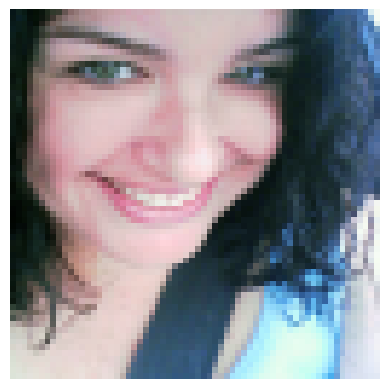

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Pretpostavimo da je vektor nazvan vec i dužine 12288
# vec = ...

# Razdvoj kanale
R = vec[:4096].reshape(64, 64)
G = vec[4096:4096*2].reshape(64, 64)
B = vec[4096*2:].reshape(64, 64)

# Kombinuj u sliku
img = np.stack([R, G, B], axis=-1)

# Ako su vrednosti u [0, 255], prebaci u [0,1] za prikaz
if img.max() > 1:
    img = img / 255.0

# Prikaži
plt.imshow(img)
plt.axis("off")
plt.show()


In [18]:
def sample_noise(batch_size=1):
    return np.random.normal(size=(batch_size, 2))

In [20]:
x = sample_noise(3)

In [21]:
print(x)

[[ 0.06199225  0.90066215]
 [ 0.9936962  -0.66611087]
 [-0.81288361  0.15340134]]
